# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_057  Q9P232              15.731
Sample_121  Q02818              17.274
Sample_168  A0A087X0K0;P39059   16.687
Sample_114  Q99972              15.676
Sample_175  H0YDE5              17.196
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups               
Sample_158  Q15847                          14.328
Sample_152  P67936                          15.859
Sample_026  A6H8L4;E7EUI5;P78536;P78536-2   14.246
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.932
            A0A075B6Q5                 12.759
            A0A075B6R2                 13.179
            A0A075B6S5                 12.424
            A0A087WSY4                 13.341
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.176
            Q9UI40;Q9UI40-2            12.927
            Q9UIW2                     13.109
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.208
            Q9UP79                     12.157
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.851,15.050,16.842,19.863,15.890,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.262,19.067,...,15.528,15.576,14.064,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.830,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.824,17.705,17.039,14.995,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.603,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.436,15.345,17.084,18.708,14.249,19.433,12.189,10.957
Sample_207,15.739,16.877,15.469,16.898,14.463,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.968,13.408,12.187,13.058,14.476,13.185,13.089,11.915,12.885,12.591
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.177,19.067,16.127,...,12.673,13.076,13.416,11.448,12.846,11.837,13.947,13.730,13.000,13.369
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.501,12.891,12.356,12.025,13.361,11.688,12.711,11.828,14.026,12.007
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.215,13.780,13.250,13.180,13.058,13.744,13.327,13.122,13.263,13.792
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.623,13.016,13.090,13.433,13.976,12.346,13.662,13.584,12.460,11.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.897,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 367.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.39it/s]

100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.16it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.42it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.99it/s]

100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.51it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.24it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.45it/s]

100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  5.00it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.74it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.26it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.12it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.90it/s]

100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.41it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.22it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.43it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.05it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.77it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.69it/s]

100%|██████████| 8/8 [00:01<00:00,  3.87it/s]

100%|██████████| 8/8 [00:01<00:00,  4.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.20it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.03it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.22it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.08it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.93it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.86it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.92it/s]

100%|██████████| 9/9 [00:02<00:00,  2.89it/s]

100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.02it/s]

 30%|███       | 3/10 [00:00<00:01,  6.01it/s]

 40%|████      | 4/10 [00:00<00:01,  4.99it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.79it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.73it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.67it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.62it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.72it/s]

100%|██████████| 10/10 [00:02<00:00,  4.69it/s]

100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.60it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.01it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.38it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.89it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.83it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.02it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.55it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.58it/s]

100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

100%|██████████| 11/11 [00:02<00:00,  3.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.04it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.68it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.41it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.18it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.25it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.38it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.37it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.48it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.48it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.95it/s]

100%|██████████| 12/12 [00:02<00:00,  4.00it/s]

100%|██████████| 12/12 [00:02<00:00,  4.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.19it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.27it/s]

 31%|███       | 4/13 [00:00<00:01,  4.87it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.45it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.32it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.31it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.41it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.02it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.16it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.09it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.03it/s]

100%|██████████| 13/13 [00:02<00:00,  4.07it/s]

100%|██████████| 13/13 [00:02<00:00,  4.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.05it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.58it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.62it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.12it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.72it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.84it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.65it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.35it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.11it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.14it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.20it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.31it/s]

100%|██████████| 14/14 [00:02<00:00,  4.39it/s]

100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.04it/s]

 20%|██        | 3/15 [00:00<00:02,  5.09it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.50it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.49it/s]

 40%|████      | 6/15 [00:01<00:02,  4.37it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.29it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.35it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.46it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.02it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.99it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.03it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.10it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.05it/s]

100%|██████████| 15/15 [00:03<00:00,  4.00it/s]

100%|██████████| 15/15 [00:03<00:00,  4.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.016          0.771 0.335       0.122   
2             0.004 0.004      0.057 0.025          0.635 0.150       0.465   
3             0.006 0.005      0.050 0.018          0.814 0.085       0.717   
4             0.004 0.003      0.046 0.017          0.813 0.081       0.771   
5             0.005 0.004      0.056 0.023          0.828 0.080       0.793   
6             0.005 0.005      0.047 0.019          0.831 0.082       0.790   
7             0.006 0.006      0.050 0.024          0.827 0.084       0.788   
8             0.004 0.003      0.055 0.022          0.837 0.076       0.833   
9             0.005 0.003      0.047 0.018          0.839 0.078       0.825   
10            0.006 0.007      0.053 0.019          0.840 0.077       0.824   
11            0.003 0.001      0.033 0.011          0.847 0.070       0.814   
12            0.003 0.000      0.042 0.019          0.835 0.082       0.805   
13            0.004 0.002      0.040 0.011          0.826 0.085       0.802   
14            0.004 0.000      0.038 0.011          0.823 0.085       0.795   
15            0.003 0.001      0.029 0.010          0.823 0.081       0.788   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.204 0.126                  0.553 0.040        0.849   
2          0.117   0.525 0.101                  0.627 0.069        0.701   
3          0.099   0.757 0.067                  0.796 0.054        0.895   
4          0.104   0.786 0.068                  0.819 0.055        0.906   
5          0.089   0.806 0.063                  0.835 0.053        0.909   
6          0.089   0.806 0.064                  0.834 0.054        0.908   
7          0.093   0.802 0.066                  0.832 0.055        0.906   
8          0.095   0.832 0.068                  0.857 0.058        0.919   
9          0.095   0.829 0.067                  0.854 0.058        0.919   
10         0.093   0.828 0.067                  0.854 0.057        0.919   
11         0.083   0.827 0.057                  0.852 0.047        0.924   
12         0.103   0.815 0.075                  0.843 0.060        0.922   
13         0.100   0.810 0.076                  0.838 0.062        0.920   
14         0.100   0.805 0.075                  0.834 0.062        0.918   
15         0.094   0.801 0.067                  0.831 0.056        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.081                  0.654 0.097        210.000 0.000  
3          0.044                  0.876 0.054        210.000 0.000  
4          0.044                  0.884 0.053        210.000 0.000  
5          0.047                  0.893 0.055        210.000 0.000  
6          0.048                  0.892 0.056        210.000 0.000  
7          0.048                  0.889 0.056        210.000 0.000  
8          0.044                  0.905 0.049        210.000 0.000  
9          0.044                  0.908 0.049        210.000 0.000  
10         0.045                  0.907 0.049        210.000 0.000  
11         0.047                  0.913 0.049        210.000 0.000  
12         0.049                  0.911 0.051        210.000 0.000  
13         0.048                  0.910 0.049        210.000 0.000  
14         0.048                  0.908 0.050        210.000 0.000  
15         0.048                  0.906 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 512.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

100%|██████████| 4/4 [00:00<00:00,  3.65it/s]

100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.78it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.22it/s]

100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.72it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.99it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.65it/s]

100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

100%|██████████| 6/6 [00:01<00:00,  4.91it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.22it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.39it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.78it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.10it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.83it/s]

100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.74it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.15it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.45it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.45it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.25it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.17it/s]

100%|██████████| 8/8 [00:01<00:00,  4.21it/s]

100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.46it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.62it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.54it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.08it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.83it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.67it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.42it/s]

100%|██████████| 9/9 [00:01<00:00,  5.48it/s]

100%|██████████| 9/9 [00:01<00:00,  5.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.61it/s]

 30%|███       | 3/10 [00:00<00:01,  5.58it/s]

 40%|████      | 4/10 [00:00<00:01,  4.86it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.26it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.06it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.03it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.91it/s]

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.30it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.16it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.40it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.79it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.51it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.26it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.29it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.12it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.30it/s]

100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

100%|██████████| 11/11 [00:02<00:00,  4.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.84it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.97it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.14it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.86it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.02it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.21it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.54it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.18it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.92it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.08it/s]

100%|██████████| 12/12 [00:02<00:00,  4.87it/s]

100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.46it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.22it/s]

 31%|███       | 4/13 [00:00<00:01,  5.37it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.82it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.55it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.48it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.60it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.60it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.49it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.43it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.56it/s]

100%|██████████| 13/13 [00:02<00:00,  4.73it/s]

100%|██████████| 13/13 [00:02<00:00,  4.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.76it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.21it/s]

 43%|████▎     | 6/14 [00:00<00:00,  8.41it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.70it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  7.20it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.21it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.05it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.86it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.25it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.28it/s]

100%|██████████| 14/14 [00:01<00:00,  6.33it/s]

100%|██████████| 14/14 [00:01<00:00,  7.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.32it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.59it/s]

 40%|████      | 6/15 [00:00<00:00,  9.52it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.07it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.98it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.88it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.81it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.77it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.64it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.55it/s]

100%|██████████| 15/15 [00:01<00:00,  8.56it/s]

100%|██████████| 15/15 [00:01<00:00,  9.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.036 0.010          0.138 0.308       0.019   
2             0.003 0.002      0.036 0.006          0.710 0.102       0.616   
3             0.003 0.000      0.035 0.004          0.796 0.101       0.686   
4             0.004 0.004      0.044 0.017          0.805 0.093       0.710   
5             0.004 0.002      0.038 0.013          0.790 0.088       0.736   
6             0.005 0.004      0.047 0.018          0.793 0.091       0.752   
7             0.005 0.005      0.050 0.022          0.799 0.090       0.758   
8             0.003 0.000      0.033 0.005          0.801 0.092       0.758   
9             0.003 0.001      0.027 0.006          0.814 0.088       0.771   
10            0.003 0.001      0.029 0.006          0.819 0.088       0.752   
11            0.003 0.000      0.033 0.005          0.806 0.085       0.781   
12            0.003 0.001      0.028 0.005          0.806 0.089       0.784   
13            0.002 0.000      0.021 0.003          0.808 0.084       0.789   
14            0.002 0.000      0.020 0.001          0.817 0.086       0.787   
15            0.002 0.000      0.020 0.000          0.809 0.085       0.785   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.048   0.032 0.078                  0.504 0.021        0.863   
2          0.115   0.652 0.085                  0.713 0.061        0.803   
3          0.119   0.732 0.092                  0.778 0.070        0.873   
4          0.124   0.747 0.085                  0.790 0.064        0.876   
5          0.121   0.756 0.083                  0.795 0.065        0.877   
6          0.115   0.767 0.081                  0.802 0.067        0.880   
7          0.115   0.771 0.077                  0.807 0.063        0.879   
8          0.112   0.773 0.078                  0.808 0.064        0.876   
9          0.111   0.787 0.078                  0.819 0.065        0.902   
10         0.119   0.778 0.083                  0.814 0.065        0.903   
11         0.110   0.788 0.076                  0.820 0.062        0.915   
12         0.107   0.790 0.074                  0.821 0.062        0.916   
13         0.103   0.793 0.072                  0.824 0.060        0.914   
14         0.103   0.796 0.072                  0.827 0.060        0.915   
15         0.108   0.792 0.073                  0.823 0.061        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.830 0.086        210.000 0.000  
2          0.069                  0.762 0.087        210.000 0.000  
3          0.056                  0.845 0.072        210.000 0.000  
4          0.055                  0.851 0.070        210.000 0.000  
5          0.053                  0.853 0.068        210.000 0.000  
6          0.056                  0.856 0.070        210.000 0.000  
7          0.057                  0.857 0.072        210.000 0.000  
8          0.058                  0.854 0.072        210.000 0.000  
9          0.052                  0.882 0.062        210.000 0.000  
10         0.053                  0.882 0.065        210.000 0.000  
11         0.049                  0.898 0.058        210.000 0.000  
12         0.049                  0.900 0.056        210.000 0.000  
13         0.049                  0.898 0.057        210.000 0.000  
14         0.049                  0.900 0.055        210.000 0.000  
15         0.049                  0.898 0.057 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1503.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 61.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.08it/s]

100%|██████████| 5/5 [00:00<00:00, 43.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.34it/s]

100%|██████████| 6/6 [00:00<00:00, 42.38it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.17it/s]

100%|██████████| 7/7 [00:00<00:00, 41.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.34it/s]

100%|██████████| 8/8 [00:00<00:00, 40.43it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.05it/s]

100%|██████████| 9/9 [00:00<00:00, 39.87it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.09it/s]

100%|██████████| 10/10 [00:00<00:00, 38.70it/s]

100%|██████████| 10/10 [00:00<00:00, 39.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.33it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.75it/s]

100%|██████████| 11/11 [00:00<00:00, 39.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.23it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.80it/s]

100%|██████████| 12/12 [00:00<00:00, 38.79it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.40it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.79it/s]

100%|██████████| 13/13 [00:00<00:00, 38.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.15it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.89it/s]

100%|██████████| 14/14 [00:00<00:00, 37.62it/s]

100%|██████████| 14/14 [00:00<00:00, 38.40it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.31it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.81it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.55it/s]

100%|██████████| 15/15 [00:00<00:00, 38.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.643 0.112       0.524   
3             0.002 0.000      0.020 0.000          0.684 0.096       0.567   
4             0.002 0.000      0.020 0.000          0.688 0.093       0.598   
5             0.002 0.000      0.020 0.000          0.757 0.087       0.623   
6             0.002 0.000      0.020 0.000          0.735 0.087       0.605   
7             0.002 0.000      0.020 0.000          0.729 0.088       0.606   
8             0.002 0.000      0.020 0.000          0.714 0.082       0.628   
9             0.002 0.000      0.020 0.000          0.710 0.078       0.620   
10            0.002 0.000      0.020 0.000          0.715 0.083       0.649   
11            0.002 0.000      0.020 0.000          0.704 0.079       0.645   
12            0.002 0.000      0.020 0.000          0.707 0.078       0.652   
13            0.002 0.000      0.020 0.000          0.708 0.088       0.644   
14            0.002 0.000      0.020 0.000          0.703 0.071       0.661   
15            0.002 0.000      0.020 0.000          0.702 0.069       0.667   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.750   
2          0.090   0.570 0.074                  0.650 0.056        0.768   
3          0.102   0.615 0.084                  0.687 0.060        0.789   
4          0.119   0.632 0.085                  0.698 0.061        0.817   
5          0.108   0.677 0.076                  0.736 0.055        0.828   
6          0.109   0.657 0.082                  0.721 0.057        0.826   
7          0.110   0.655 0.083                  0.719 0.057        0.823   
8          0.109   0.662 0.083                  0.721 0.058        0.821   
9          0.108   0.656 0.082                  0.717 0.056        0.816   
10         0.097   0.674 0.067                  0.727 0.051        0.827   
11         0.101   0.667 0.068                  0.721 0.053        0.827   
12         0.100   0.673 0.067                  0.726 0.052        0.826   
13         0.094   0.669 0.069                  0.722 0.055        0.823   
14         0.099   0.676 0.066                  0.727 0.051        0.821   
15         0.105   0.679 0.068                  0.729 0.050        0.818   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.699 0.082        210.000 0.000  
2          0.070                  0.701 0.096        210.000 0.000  
3          0.061                  0.732 0.083        210.000 0.000  
4          0.055                  0.761 0.078        210.000 0.000  
5          0.055                  0.780 0.074        210.000 0.000  
6          0.054                  0.779 0.072        210.000 0.000  
7          0.055                  0.775 0.074        210.000 0.000  
8          0.052                  0.768 0.073        210.000 0.000  
9          0.053                  0.764 0.073        210.000 0.000  
10         0.049                  0.771 0.066        210.000 0.000  
11         0.051                  0.767 0.070        210.000 0.000  
12         0.051                  0.765 0.070        210.000 0.000  
13         0.053                  0.762 0.074        210.000 0.000  
14         0.052                  0.760 0.074        210.000 0.000  
15         0.052                  0.757 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,7,15
score_time,2,7,15
test_precision,11,10,5
test_recall,8,13,15
test_f1,8,14,15
test_balanced_accuracy,8,14,5
test_roc_auc,11,12,5
test_average_precision,11,12,5
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.86it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.35it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.31it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  8.90it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.79it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.73it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.74it/s]

100%|██████████| 12/12 [00:01<00:00,  8.67it/s]

100%|██████████| 12/12 [00:01<00:00,  9.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.08it/s]

100%|██████████| 5/5 [00:00<00:00, 43.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.83it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.99it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.88it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.35it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.00it/s]

100%|██████████| 11/11 [00:01<00:00, 10.59it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


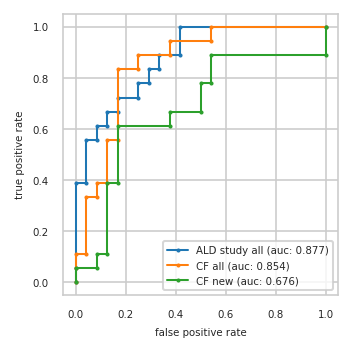

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.389  0.000 0.111  0.083 0.056
3          0.042 0.389  0.042 0.111  0.083 0.111
4          0.042 0.556  0.042 0.333  0.125 0.111
5          0.083 0.556  0.083 0.333  0.125 0.389
6          0.083 0.611  0.083 0.389  0.167 0.389
7          0.125 0.611  0.125 0.389  0.167 0.611
8          0.125 0.667  0.125 0.556  0.375 0.611
9          0.167 0.667  0.167 0.556  0.375 0.667
10         0.167 0.722  0.167 0.833  0.500 0.667
11         0.250 0.722  0.250 0.833  0.500 0.778
12         0.250 0.778  0.250 0.889  0.542 0.778
13         0.292 0.778  0.375 0.889  0.542 0.889
14         0.292 0.833  0.375 0.944  1.000 0.889
15         0.333 0.833  0.542 0.944  1.000 1.000
16         0.333 0.889  0.542 1.000    NaN   NaN
17         0.417 0.889  1.000 1.000    NaN   NaN
18         0.417 1.000    NaN   NaN    NaN   NaN
19         1.000 1.000    NaN   NaN    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2,H0Y7T8;P49418;P49418-2
2,P09486,P02741,J3KSJ8;Q9UD71;Q9UD71-2
3,A6NFX8;Q9UKK9,P04075,P31321
4,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q96GD0
5,P14174,P61981,None
6,P61981,P14174,None
7,Q9Y2T3;Q9Y2T3-3,Q14894,None
8,P63104,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


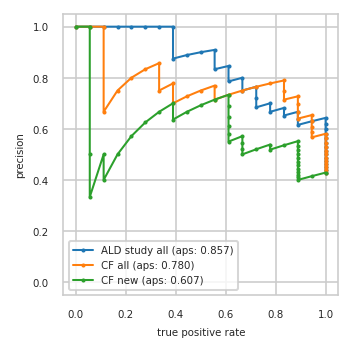

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.400 0.889
3          0.462 1.000     0.462 1.000     0.410 0.889
4          0.474 1.000     0.474 1.000     0.421 0.889
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.500 0.667
19         0.652 0.833     0.696 0.889     0.522 0.667
20         0.682 0.833     0.727 0.889     0.545 0.667
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.700 0.778     0.750 0.833     0.550 0.611
23         0.684 0.722     0.789 0.833     0.579 0.611
24         0.722 0.722     0.778 0.778     0.611 0.611
25         0.765 0.722     0.765 0.722     0.647 0.611
26         0.750 0.667     0.750 0.667     0.688 0.611
27         0.800 0.667     0.733 0.611     0.733 0.611
28         0.786 0.611     0.714 0.556     0.714 0.556
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.833 0.556     0.750 0.500     0.667 0.444
31         0.909 0.556     0.727 0.444     0.636 0.389
32         0.900 0.500     0.700 0.389     0.700 0.389
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     0.667 0.111     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


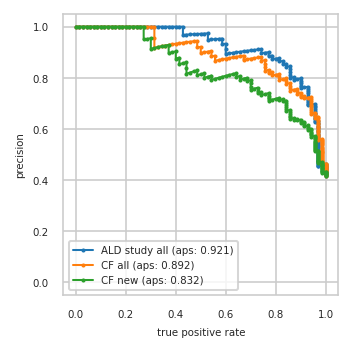

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


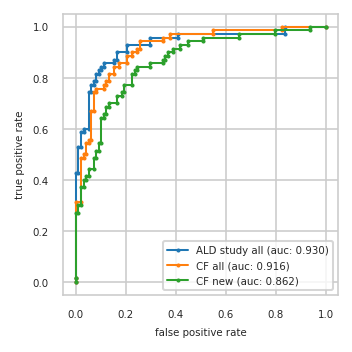

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}